In [89]:
import os
import cv2
from scipy.stats import skew, kurtosis
import pandas as pd
import numpy as np
CSV_PATH = r"IITKGP NEONATAL DATA\Updated_CSV.csv"
IMG_DIR = r"IITKGP NEONATAL DATA\Photos"
df = pd.read_csv(CSV_PATH)
print(df.columns)
image_data = []
labels = []
TARGET_SIZE = (256, 256)
for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["Image_idx"])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, TARGET_SIZE)
        image_data.append(img)
        labels.append(row["Total bilirubin"])
    else:
        print(f"Warning: Image not found or unreadable - {img_path}")
image_data = np.array(image_data)
labels = np.array(labels)
print(f"Loaded {len(image_data)} images.")

Index(['S NO.', 'BABY NAME', 'Sex', 'CR NUMBER', 'Total bilirubin',
       'Direct bilirbin', 'Image_idx'],
      dtype='object')
Loaded 53 images.


In [90]:
from tensorflow.keras.models import load_model

model = load_model("ML+CNN_model.h5")


In [91]:
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rgb_input (InputLayer)      [(None, 24, 1)]              0         []                            
                                                                                                  
 hsv_input (InputLayer)      [(None, 24, 1)]              0         []                            
                                                                                                  
 conv1d_48 (Conv1D)          (None, 24, 8)                32        ['rgb_input[0][0]']           
                                                                                                  
 conv1d_52 (Conv1D)          (None, 24, 8)                32        ['hsv_input[0][0]']           
                                                                                            

In [100]:
def white_balance(img):
    avg_b = np.mean(img[:,:,0])
    avg_g = np.mean(img[:,:,1])
    avg_r = np.mean(img[:,:,2])
    avg_gray = (avg_b + avg_g + avg_r) / 3
    img[:,:,0] = np.minimum(img[:,:,0] * (avg_gray / avg_b), 255)
    img[:,:,1] = np.minimum(img[:,:,1] * (avg_gray / avg_g), 255)
    img[:,:,2] = np.minimum(img[:,:,2] * (avg_gray / avg_r), 255)
    return img.astype(np.uint8)

def crop_center(img, fraction=0.35):
    h, w = img.shape[:2]
    ch, cw = int(h * fraction), int(w * fraction)
    start_x, start_y = (w - cw) // 2, (h - ch) // 2
    return img[start_y:start_y+ch, start_x:start_x+cw]

def select_chest_area_manual(image):
    """
    Manually select chest area using OpenCV ROI selector.
    """
    clone = image.copy()
    cv2.namedWindow("Select Chest Area", cv2.WINDOW_NORMAL)
    bbox = cv2.selectROI("Select Chest Area", clone, fromCenter=False, showCrosshair=True)
    cv2.destroyAllWindows()
    x, y, w, h = bbox
    if w == 0 or h == 0:
        print("No region selected. Skipping this image.")
        return None
    return image[y:y+h, x:x+w]

def extract_color_features(skin_img):
    features = {}
    b, g, r = cv2.split(skin_img)
    features['rgb'] = [r, g, b]
    hsv = cv2.cvtColor(skin_img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    features['hsv'] = [h, s, v]
    return features

def extract_pixel_statistics(channel):
    mask = channel > 0
    if np.sum(mask) == 0:
        return np.zeros(8)
    pixels = channel[mask]
    return np.array([
        np.mean(pixels),
        np.std(pixels),
        skew(pixels),
        kurtosis(pixels),
        np.median(pixels),
        np.percentile(pixels, 25),
        np.percentile(pixels, 75),
        np.max(pixels) - np.min(pixels)
    ])

def preprocess_images_dual(images):
    rgb_features_all = []
    hsv_features_all = []
    for img in images:
        balanced = white_balance(img)
        skin = select_chest_area_manual(balanced)
        color_features = extract_color_features(skin)
        rgb_stats = []
        hsv_stats = []
        for channel in color_features['rgb']:
            rgb_stats.extend(extract_pixel_statistics(channel))
        for channel in color_features['hsv']:
            hsv_stats.extend(extract_pixel_statistics(channel))
        rgb_features_all.append(rgb_stats)
        hsv_features_all.append(hsv_stats)
    return np.array(rgb_features_all), np.array(hsv_features_all)

In [101]:
rgb_features, hsv_features = preprocess_images_dual(image_data)


In [102]:
from sklearn.preprocessing import MinMaxScaler
scaler_rgb = MinMaxScaler()
scaler_hsv = MinMaxScaler()

rgb_features_scaled = scaler_rgb.fit_transform(rgb_features)
hsv_features_scaled = scaler_hsv.fit_transform(hsv_features)

# Reshape the features
rgb_features_reshaped = rgb_features_scaled.reshape(-1, 24, 1)
hsv_features_reshaped = hsv_features_scaled.reshape(-1, 24, 1)


In [109]:
sample_rgb = rgb_features_scaled[24].reshape(1, 24, 1)
sample_hsv = hsv_features_scaled[24].reshape(1, 24, 1)

pred = model.predict([sample_rgb, sample_hsv]).flatten()[0]
print("Prediction:", pred)
print(labels[24])

1/1 [==============================] - 0s 19ms/step
Prediction: 22.366682
20.7


In [104]:
predictions = model.predict([rgb_features_reshaped, hsv_features_reshaped]).flatten()


2/2 [==============================] - 0s 2ms/step


In [113]:
print("Predicted Value\t|\tReal Value")
print("-" * 30)
for pred, real in zip(predictions, labels):
    print(f"{pred:.4f}\t\t|\t{real:.4f}")


Predicted Value	|	Real Value
------------------------------
18.0425		|	9.9400
2.1745		|	7.5000
5.3417		|	8.3200
7.9684		|	8.5200
3.1221		|	14.2000
3.7257		|	7.4500
3.5148		|	10.4100
7.0670		|	13.9100
8.7558		|	9.1200
7.3401		|	11.5400
3.3474		|	14.8100
10.0665		|	16.7000
10.8627		|	10.1500
3.2598		|	16.1900
7.6708		|	9.8900
4.5299		|	9.1800
9.7882		|	10.7800
3.2109		|	10.6500
16.6532		|	11.6700
10.8156		|	8.7700
10.3478		|	9.3000
4.0129		|	7.6000
14.9773		|	11.3600
15.6908		|	20.6000
22.3667		|	20.7000
12.3002		|	12.7000
5.7325		|	9.5000
5.5552		|	6.9800
9.0465		|	6.9800
3.4547		|	17.4000
5.2843		|	9.4300
7.1720		|	12.1700
5.5616		|	12.7500
4.1088		|	9.7000
5.5939		|	7.0600
16.9543		|	8.4500
17.7800		|	12.5000
8.9844		|	11.3700
8.8481		|	10.3000
10.9328		|	10.6500
8.7308		|	10.2400
11.1507		|	15.8400
11.6430		|	9.9800
3.7304		|	8.9100
4.9432		|	8.7400
11.8663		|	8.7900
20.6838		|	10.1500
6.7820		|	10.8000
13.4746		|	12.9700
15.7245		|	16.7900
14.6122		|	15.5900
9.2675		|	12.2200
17.920

In [114]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(labels, predictions)
r2 = r2_score(labels, predictions)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error: 4.3693
R² Score: -1.8733


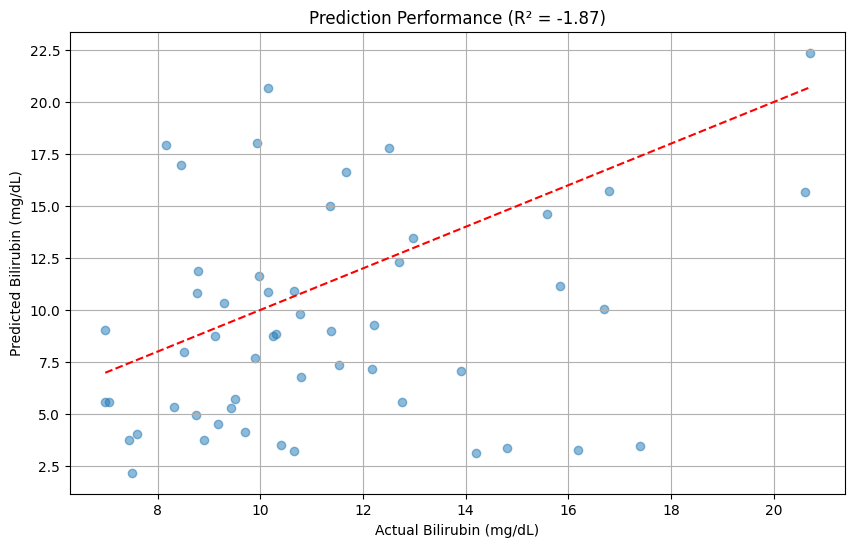

In [115]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(labels, predictions, alpha=0.5)
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], 'r--')
plt.xlabel('Actual Bilirubin (mg/dL)')
plt.ylabel('Predicted Bilirubin (mg/dL)')
plt.title(f'Prediction Performance (R² = {r2:.2f})')
plt.grid(True)
plt.show()